In [1]:
import os
import glob
import pandas as pd
import numpy as np
from nilearn.input_data import NiftiMasker
from nilearn.image import load_img
from nilearn.masking import apply_mask

In [2]:
# Settings
#data_dir = '/SCRATCH/users/alexandresayal/BIDS-BRAINPLAYBACK-TASK2/'
data_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep23"
task_label = "02a"
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
group_fig_dir = os.path.join(data_dir,"derivatives","nilearn_glm","group_figures")
group_tab_dir = os.path.join(data_dir,"derivatives","nilearn_glm","group_tables")
group_roi_dir = os.path.join(data_dir,"derivatives","nilearn_glm","group_rois")

In [3]:
# subject list
subject_list = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,"sub-*"))]
subject_list.sort()
subject_list

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17']

In [4]:
contrasts_renamed = ['All',
                     'JoyfulActivation', 'Nostalgia', 'Peacefulness', 'Power', 'Sadness', 'Tenderness', 'Tension', 'Transcendence', 'Wonder',
                     'Sublimity', 'Vitality', 'Unease', 'SublimityMinusVitality', 'VitalityMinusUnease', 'UneaseMinusSublimity']

In [5]:
# find rois in group_roi_dir - the .nii.gz files start with 'mask_'
roi_files = glob.glob(os.path.join(group_roi_dir, 'mask_*.nii.gz'))
roi_files

# create roi_labels from roi_files
roi_labels = [os.path.basename(roi_file).replace('mask_','').replace('.nii.gz','') for roi_file in roi_files]
roi_labels


['clusterid-1',
 'clusterid-2',
 'clusterid-3',
 'clusterid-4',
 'clusterid-5',
 'clusterid-6',
 'clusterid-7',
 'clusterid-8',
 'clusterid-9',
 'clusterid-10',
 'clusterid-11',
 'clusterid-12',
 'clusterid-13']

In [6]:
# extract z value from ROIs

# create a data frame of the z values for each ROI and each contrast
df = pd.DataFrame(columns=['ROI', 'Contrast', 'z_value'])

for rr in range(len(roi_files)):

    roi_path = roi_files[rr]

    for cc in range(len(contrasts_renamed)):

        map_path = os.path.join(out_dir_group,f'group_task-02a_stat-z_con-{contrasts_renamed[cc]}.nii.gz')

        z_val = np.mean(apply_mask(map_path, roi_path))

        df.loc[len(df)] = [roi_labels[rr], contrasts_renamed[cc], z_val]   

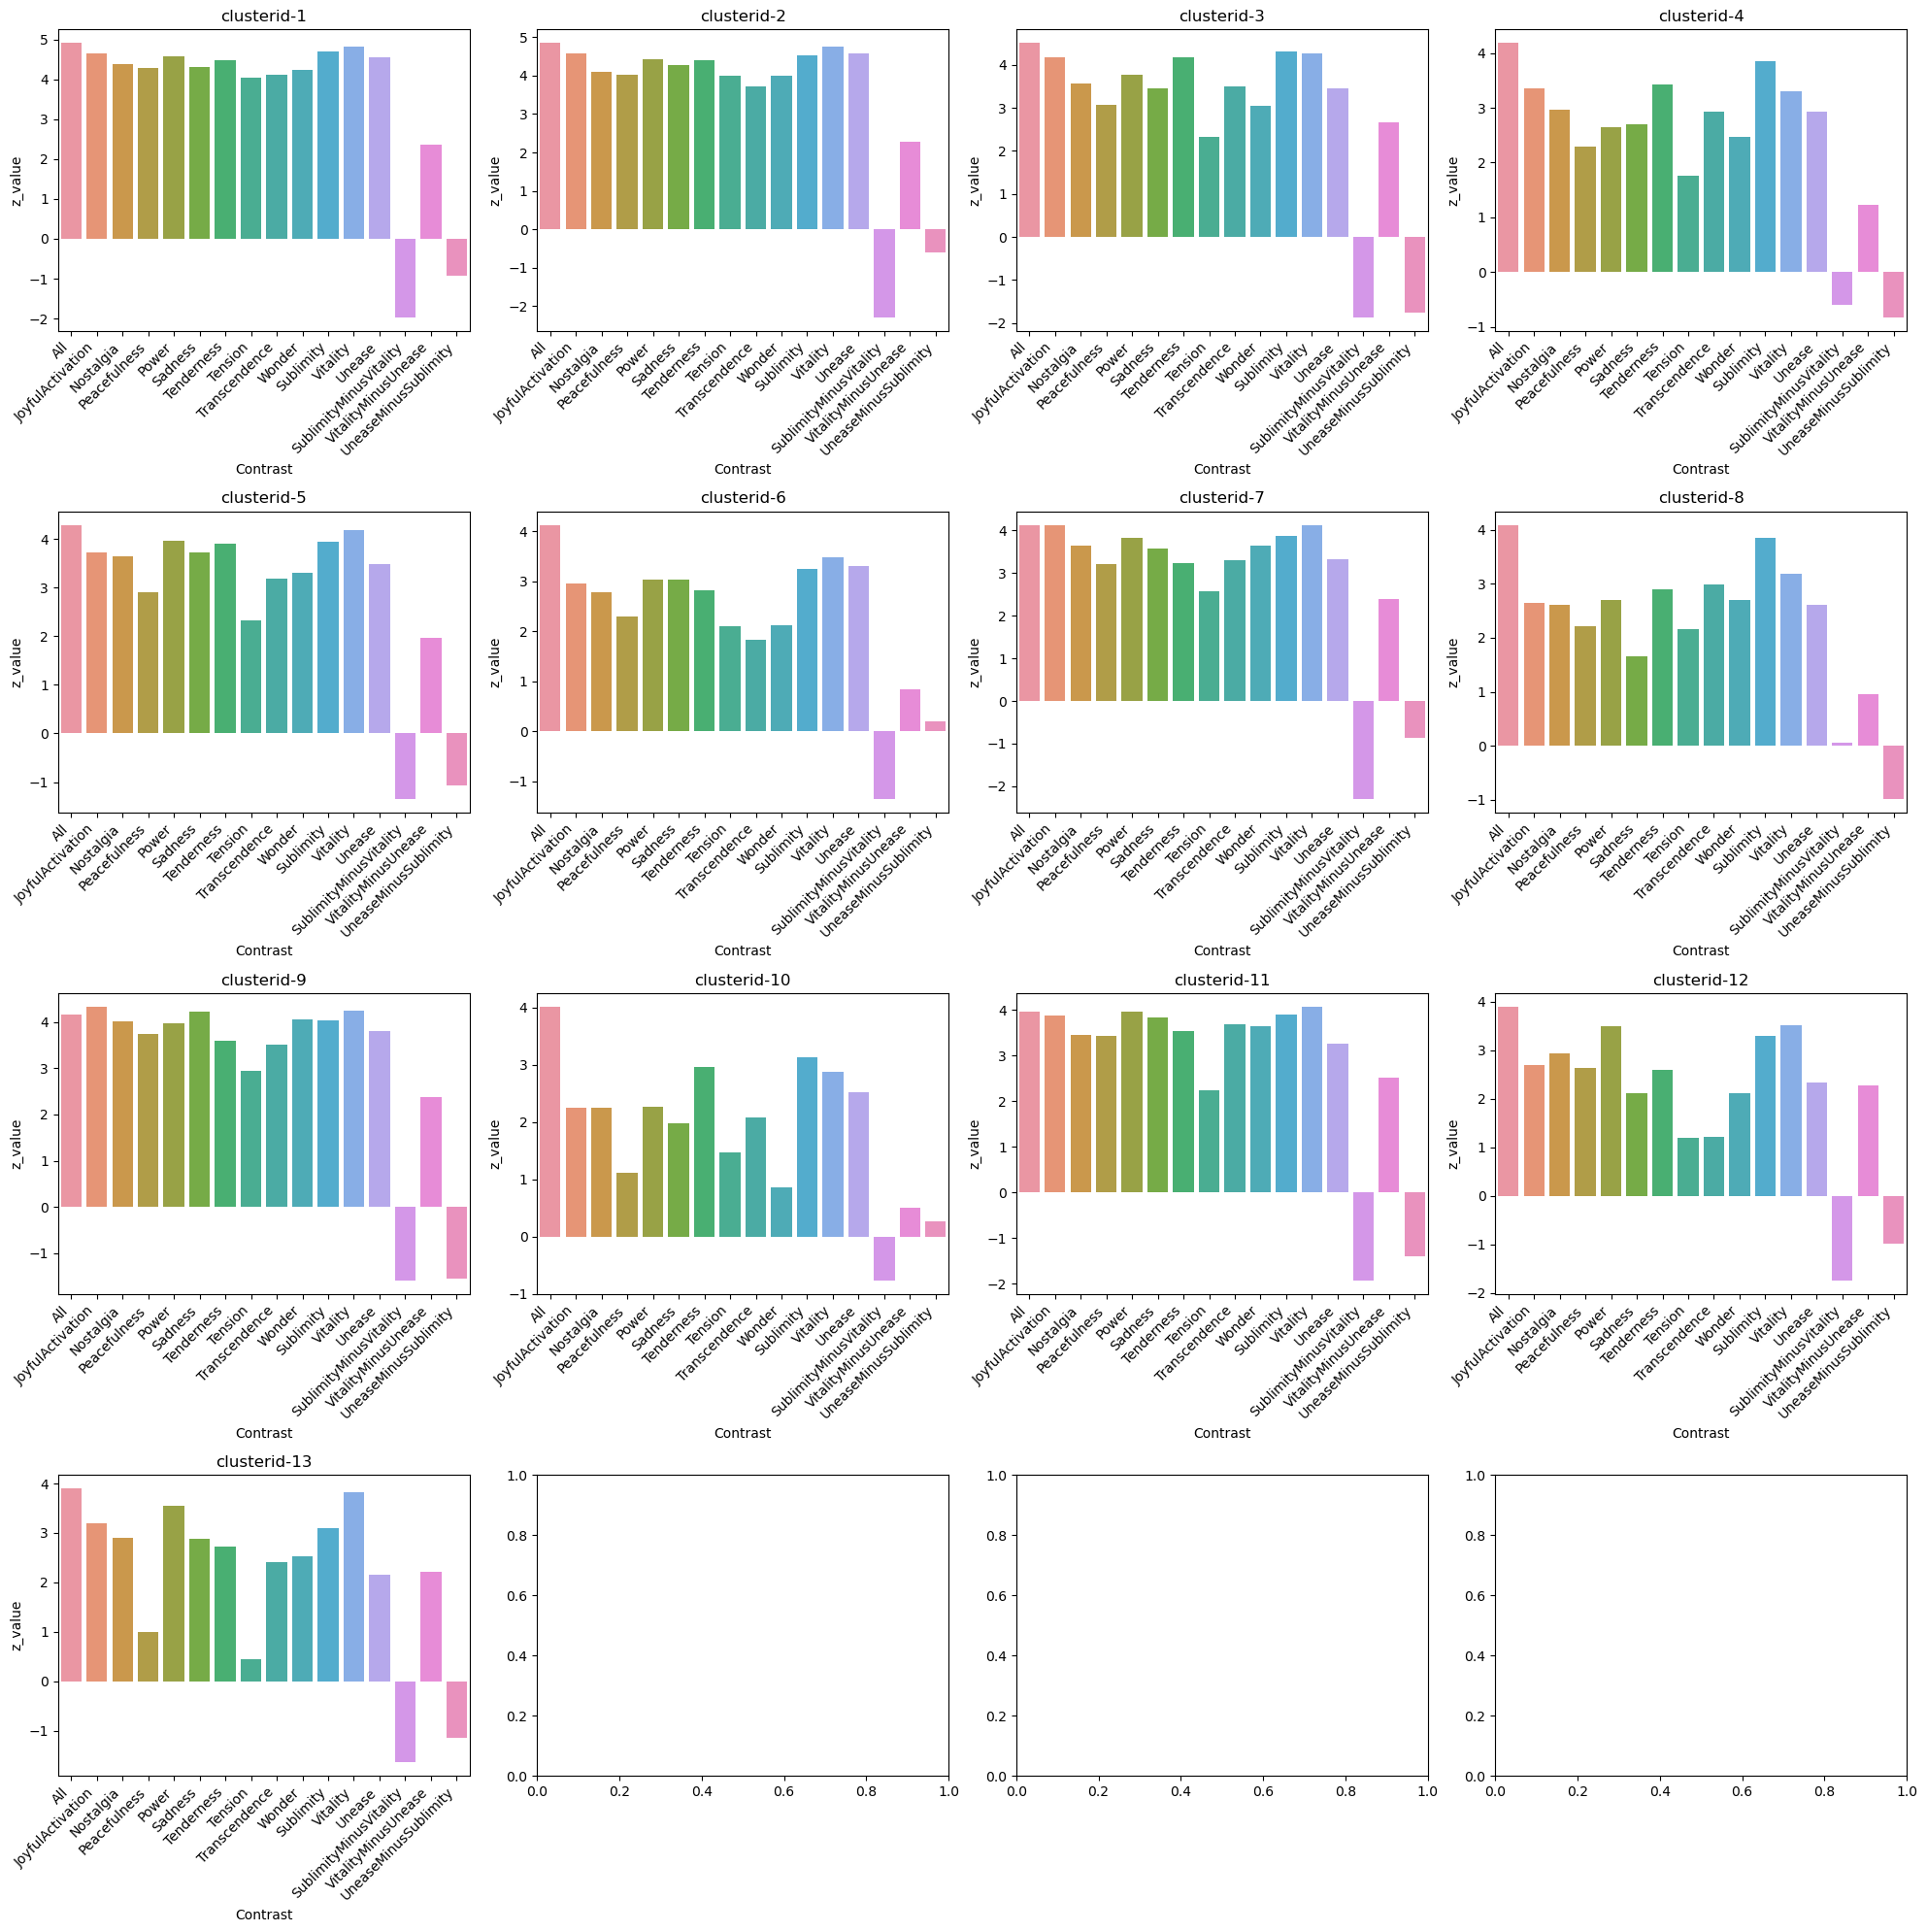

In [7]:
# create subplot for all ROIs to show barplots with the z values per condition
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for rr in range(len(roi_files)):
    sns.barplot(x='Contrast', y='z_value', data=df[df['ROI']==roi_labels[rr]], ax=ax[rr//4, rr%4])
    ax[rr//4, rr%4].set_title(roi_labels[rr])
    ax[rr//4, rr%4].set_xticklabels(ax[rr//4, rr%4].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()


In [8]:
# extract z value from ROIs per subject

# create a data frame of the z values for each ROI and each contrast
df_ss = pd.DataFrame(columns=['ROI', 'contrast', 'subject', 'z_value'])

for rr in range(len(roi_files)):

    roi_path = roi_files[rr]

    for cc in range(len(contrasts_renamed)):

        for sub in range(len(subject_list)):

            map_path = os.path.join(out_dir,f'{subject_list[sub]}_task-02a_stat-z_con-{contrasts_renamed[cc]}.nii.gz')

            z_val = np.mean(apply_mask(map_path, roi_path))

            df_ss.loc[len(df_ss)] = [roi_labels[rr], contrasts_renamed[cc], subject_list[sub], z_val]   

In [9]:
df_ss.shape

(3536, 4)

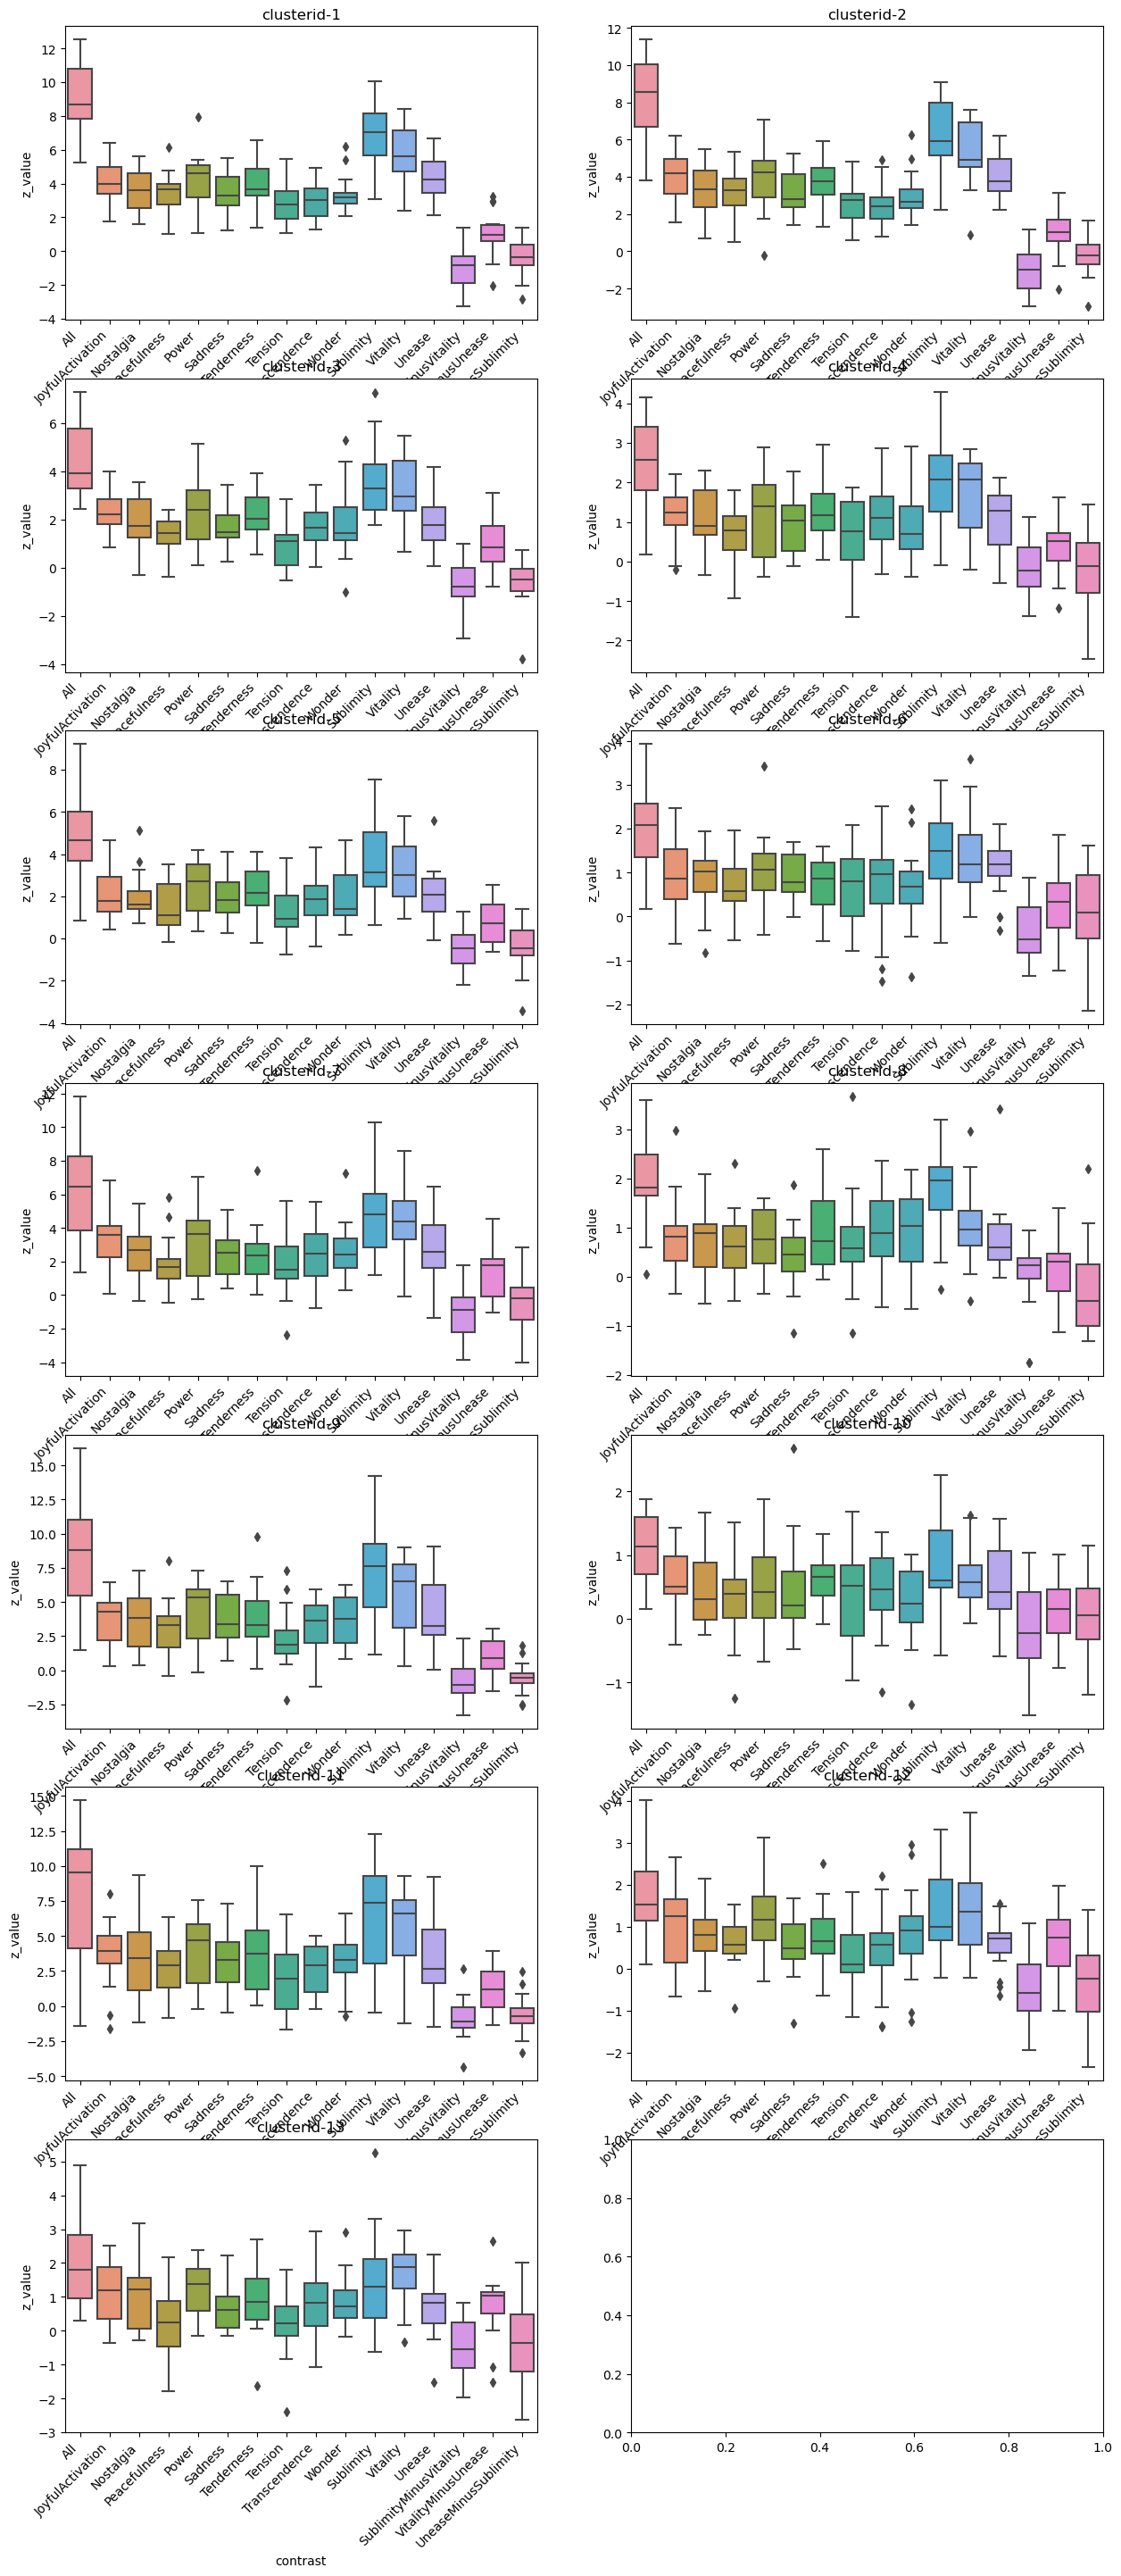

In [10]:
# create subplot for all ROIs to show boxplot with the z values per condition for all subjects
fig, ax = plt.subplots(7, 2, figsize=(15, 35))

for rr in range(len(roi_files)):
    sns.boxplot(x='contrast', y='z_value', data=df_ss[df_ss['ROI']==roi_labels[rr]], ax=ax[rr//2, rr%2])
    ax[rr//2, rr%2].set_title(roi_labels[rr])
    ax[rr//2, rr%2].set_xticklabels(ax[rr//2, rr%2].get_xticklabels(), rotation=45, ha='right')


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



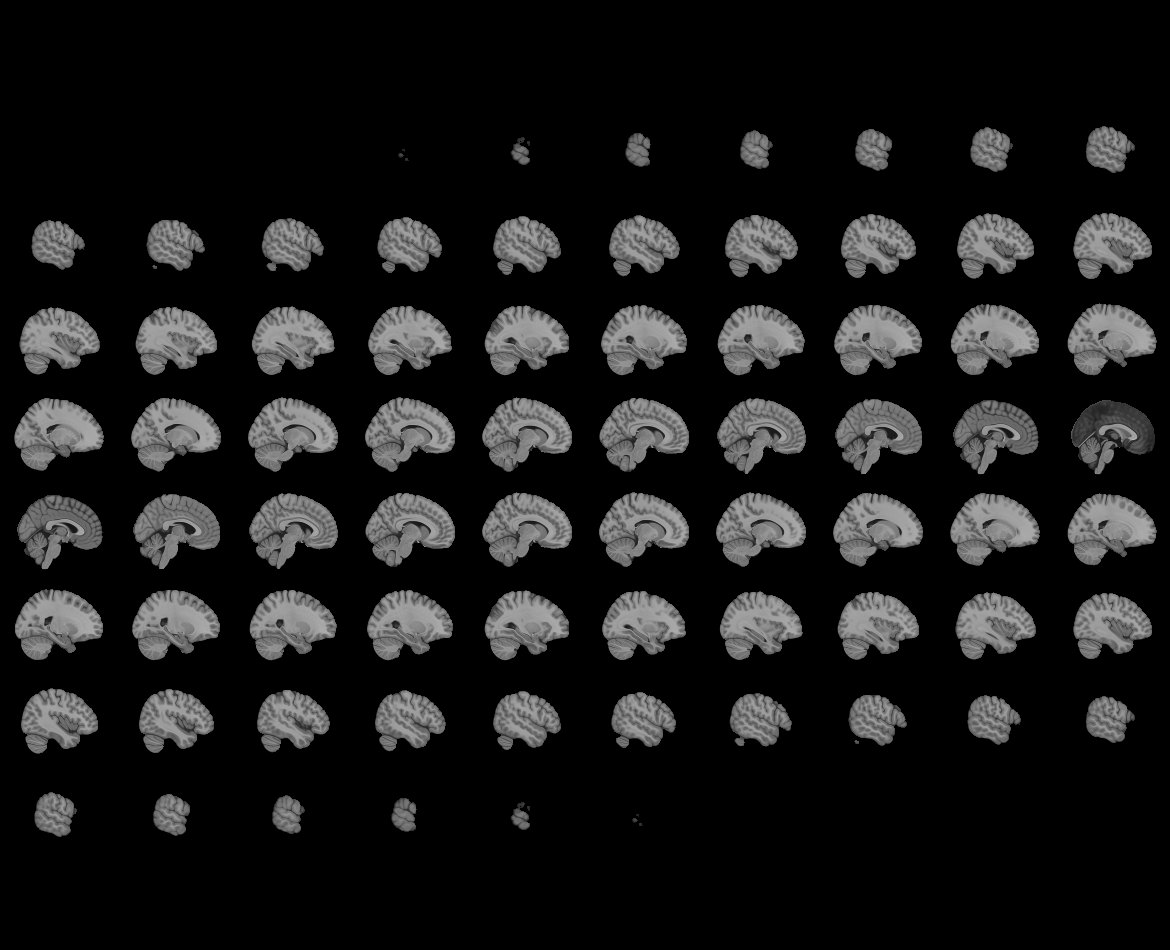
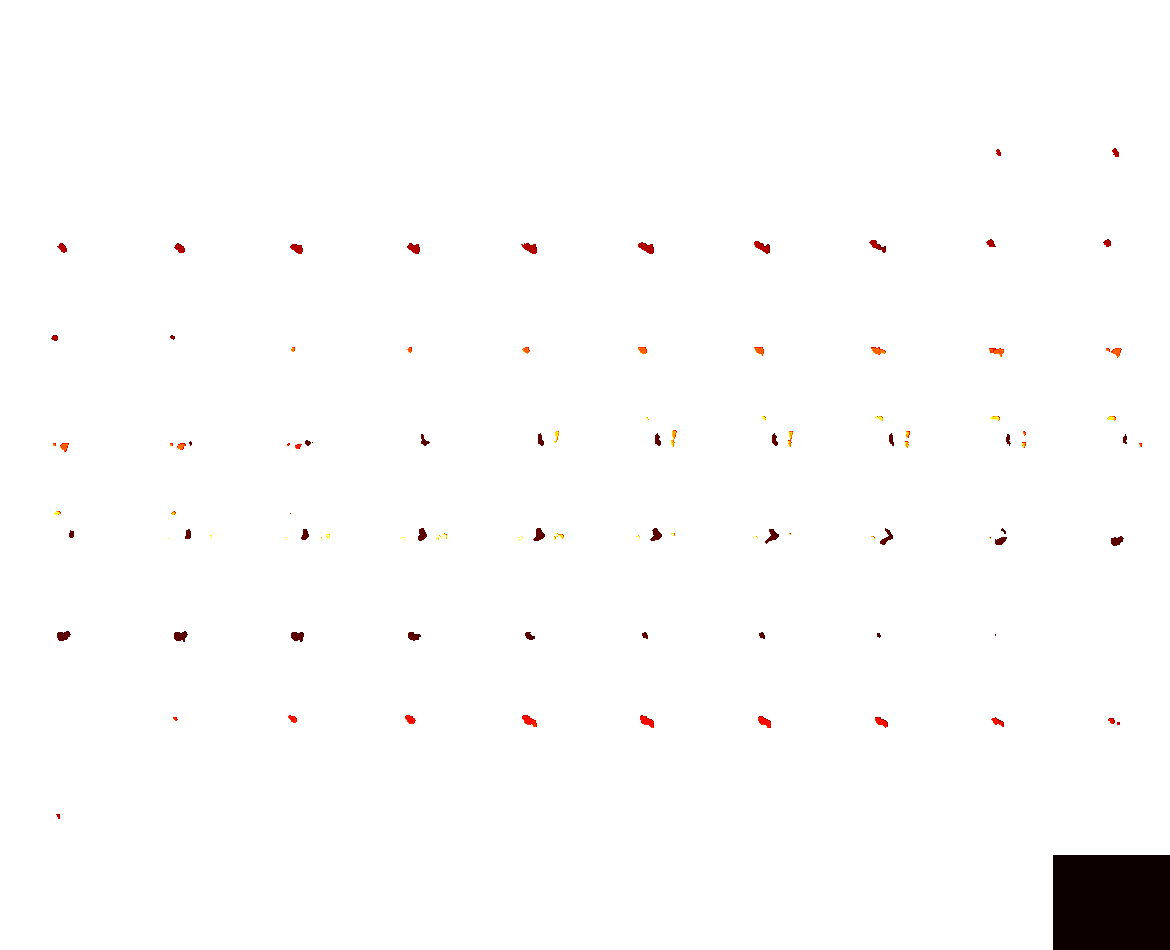

In [11]:
# fetch the roi maps from Koelsch 2020 meta analysis
koelsch_file = os.path.join('..','data','koelsch','Meta_analysis_C05_1k_clust_MNI.nii.gz')
koelsch_img = load_img(koelsch_file)
# koelsch_labels = ['R_hippocampal','R_amygdala','R_NAc_ventral_striatum',
#                   'R_caudate_nucleus','L_NAc_ventral_striatum','L_caudate_nucleus',
#                   ]
# plot koelsch_img values that are equal to 1 with view_img
from nilearn import plotting
from nilearn.image import math_img


# resample koelsch_img to the same resolution as the group z maps
from nilearn.image import resample_to_img
koelsch_img_resampled = resample_to_img(koelsch_img, map_path, interpolation='nearest')

plotting.view_img(koelsch_img_resampled)


In [12]:
# find unique values in koelsch_img_resampled
np.unique(koelsch_img_resampled.get_fdata())

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [13]:
# extract z values from Koelsch ROIs and boxplot them per condition
# create a data frame of the z values for each ROI and each contrast
df_koelsch = pd.DataFrame(columns=['ROI', 'contrast', 'subject', 'z_value'])

for rr in range(1,7):
    
        roi_path = math_img(f'(img == {rr})', img=koelsch_img_resampled)
    
        for cc in range(len(contrasts_renamed)):
    
            for sub in range(len(subject_list)):
    
                map_path = os.path.join(out_dir,f'{subject_list[sub]}_task-02a_stat-z_con-{contrasts_renamed[cc]}.nii.gz')
    
                z_val = np.mean(apply_mask(map_path, roi_path))
    
                df_koelsch.loc[len(df_koelsch)] = [f'Koelsch_{rr}', contrasts_renamed[cc], subject_list[sub], z_val]


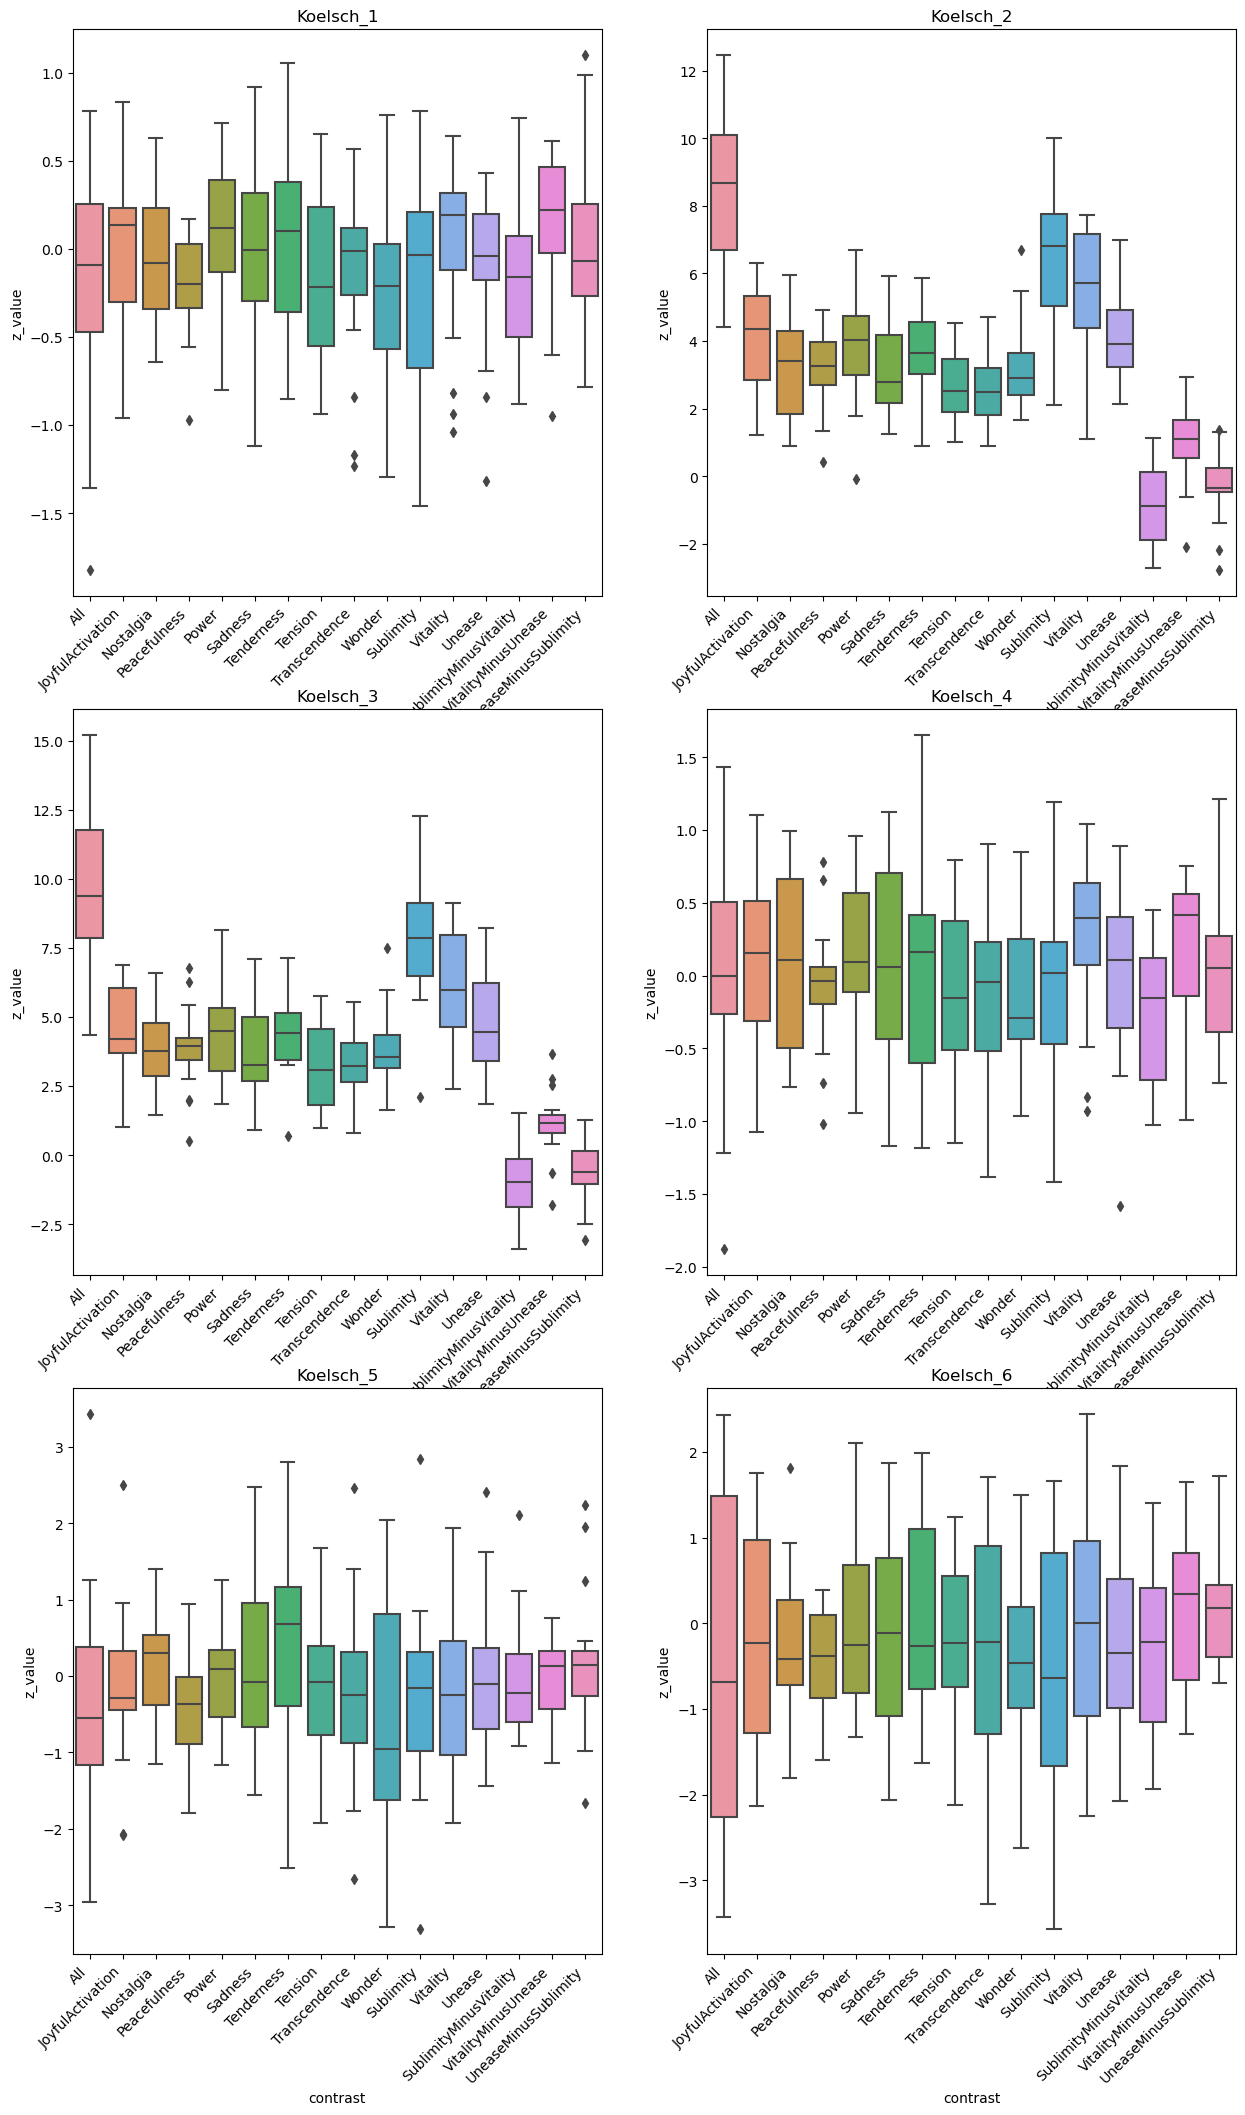

In [14]:
# create subplot for all ROIs to show boxplot with the z values per condition for all subjects
fig, ax = plt.subplots(3, 2, figsize=(15, 25))

for rr in range(1,7):
    sns.boxplot(x='contrast', y='z_value', data=df_koelsch[df_koelsch['ROI']==f'Koelsch_{rr}'], ax=ax[(rr-1)//2, (rr-1)%2])
    ax[(rr-1)//2, (rr-1)%2].set_title(f'Koelsch_{rr}')
    ax[(rr-1)//2, (rr-1)%2].set_xticklabels(ax[(rr-1)//2, (rr-1)%2].get_xticklabels(), rotation=45, ha='right')

# Spheres
https://docs.google.com/spreadsheets/d/1hppc80VakrEwtmwH3o1wgbAtSD-AsT4h_t3B3IX4wHw/edit?pli=1#gid=1645002419

In [16]:
# load tsv file with the peak coordinates
peak_file = os.path.join('..','data','koelsch','clusters_peak_MNI.csv')

df_peak = pd.read_csv(peak_file, sep=',')
df_peak

Label   X   Y   Z  systemX  systemY  systemZ  systemX2mm  \
0   R_anterior_hippocampus  25 -12 -17       65      114       55          33   
1               R_amygdala  21  -2 -16       69      124       56          35   
2                    R_nac   9  11  -6       81      137       66          41   
3                R_caudate   9   7   4       81      133       76          41   
4                    L_nac -12  13  -8      102      139       64          51   
5                L_caudate  -8   9   3       98      135       75          49   
6              L_auditory1 -53  -4  -1      143      122       71          72   
7              L_auditory2 -51 -15   1      141      111       73          71   
8          L_par_operculum -44 -28  10      134       98       82          67   
9              R_auditory1  51 -15   2       39      111       74          20   
10             R_auditory2  53  -2  -3       37      124       69          19   
11              L_amygdala -18  -4 -18      108      122       54          54   
12  L_anterior_hippocampus -29 -14 -16      119      112       56          60   
13      L_hippocampal_form -28 -21 -17      118      105       55          59   
14                   L_acc  -8  41  15       98      167       87          49   
15                   L_s32  -8  43  -7       98      169       65          49   
16                   L_pcc  -3 -26  43       93      100      115          47   
17                   L_mcc  -5 -18  41       95      108      113          48   
18                   R_fp2   7  53   4       83      179       76          42   
19                   R_p24  11  42   4       83      168       76          40   
20                   R_p32   7  40  -3       83      166       69          42   
21        R_inf_colliculus   6 -31 -15       84       95       57          42   
22     R_medial_geniculate  11 -27 -12       79       99       60          40   

    systemY2mm  systemZ2mm  
0           57          27  
1           62          28  
2           68          33  
3           66          38  
4           69          32  
5           67          37  
6           61          35  
7           55          36  
8           49          41  
9           55          37  
10          62          34  
11          61          27  
12          56          28  
13          52          27  
14          83          43  
15          84          32  
16          50          57  
17          54          56  
18          89          38  
19          84          38  
20          83          34  
21          47          28  
22          49          30

In [17]:
# generate spherical masks for each peak with a radius of 6mm using nilearn.maskers.NiftiSpheresMasker

from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    seeds=df_peak[['X', 'Y', 'Z']].values,
    radius=5,
    detrend=False,
    standardize=False,
    allow_overlap=True,
)

In [18]:
masker.fit()

report = masker.generate_report()
report

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/maskers/nifti_spheres_masker.py:445: UserWarning: No image provided to fit in NiftiSpheresMasker. Spheres are plotted on top of the MNI152 template.
  warnings.warn(msg)


In [19]:
df_koelsch_spheres = pd.DataFrame(columns=['ROI', 'contrast', 'subject', 'z_value'])

for cc in range(len(contrasts_renamed)):

    for sub in range(len(subject_list)):

        map_path = os.path.join(out_dir,f'{subject_list[sub]}_task-02a_stat-z_con-{contrasts_renamed[cc]}.nii.gz')

        z_vals_roi = masker.fit_transform(map_path)

        for rr in range(z_vals_roi.shape[1]):
            df_koelsch_spheres.loc[len(df_koelsch_spheres)] = [df_peak['Label'][rr], contrasts_renamed[cc], subject_list[sub], z_vals_roi[0][rr]]


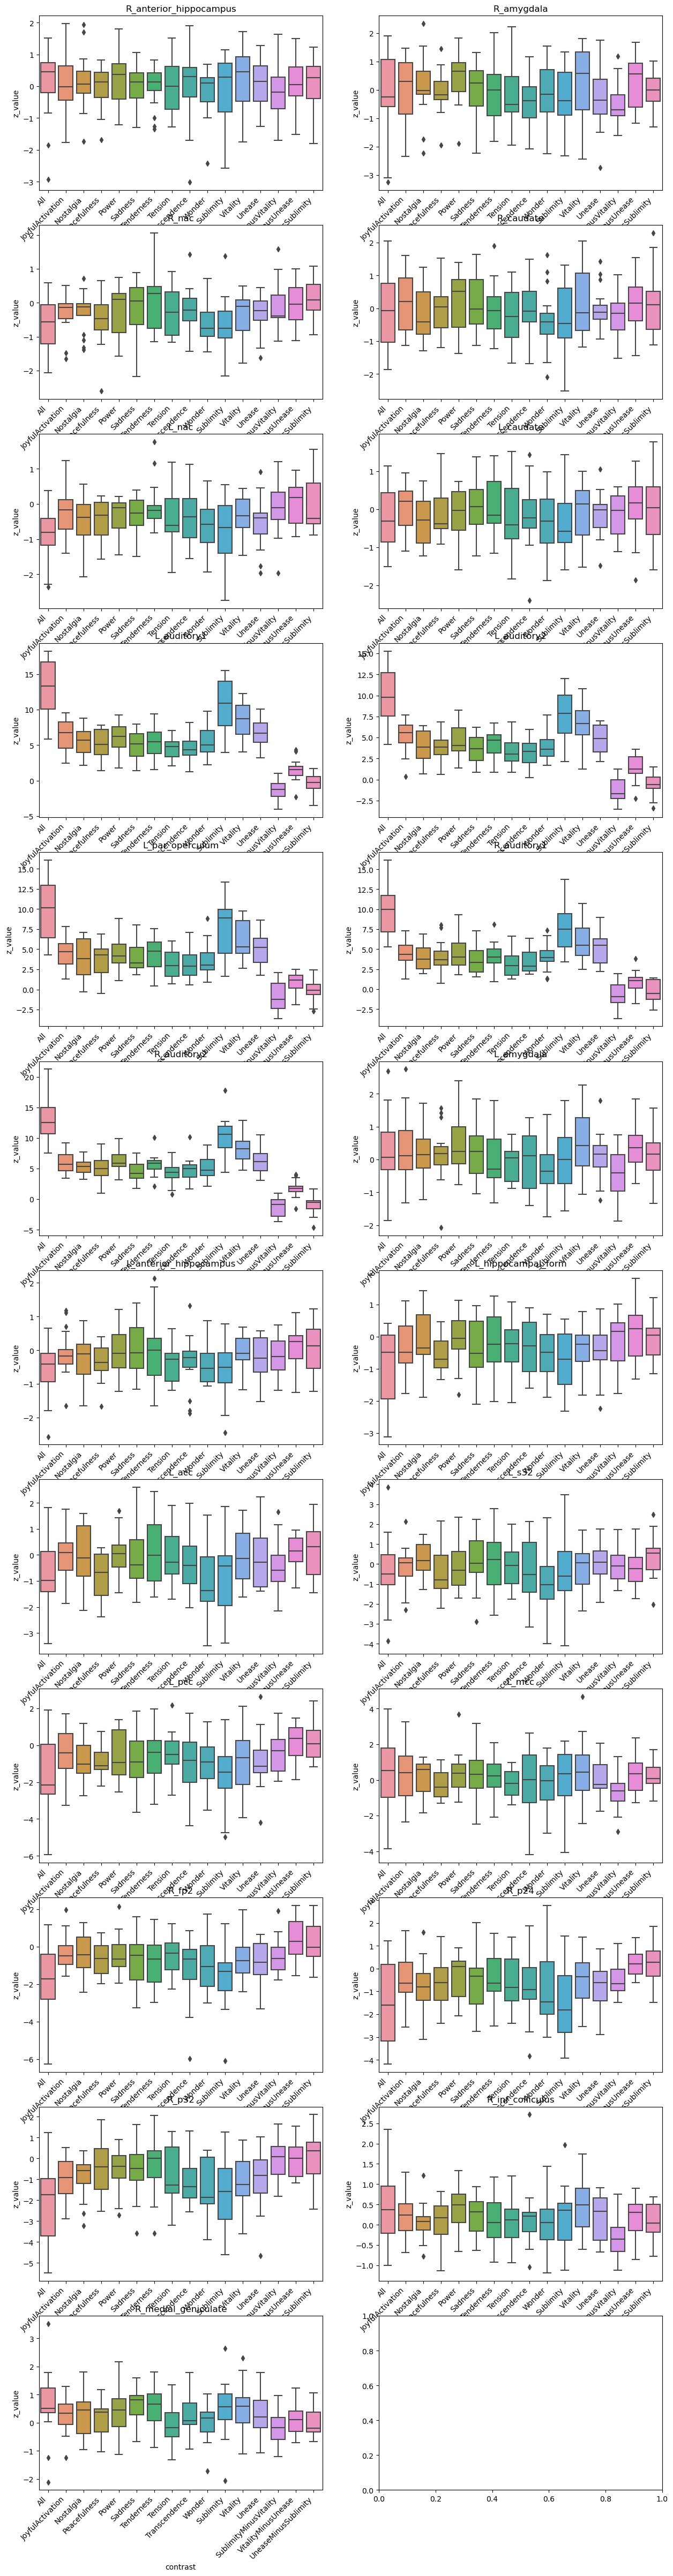

In [20]:
# boxplot the z values for each peak (total of 23) for all conditions
fig, ax = plt.subplots(12, 2, figsize=(15, 60))

for rr in range(23):
    sns.boxplot(x='contrast', y='z_value', data=df_koelsch_spheres[df_koelsch_spheres['ROI']==df_peak['Label'][rr]], ax=ax[rr//2, rr%2])
    ax[rr//2, rr%2].set_title(df_peak['Label'][rr])
    ax[rr//2, rr%2].set_xticklabels(ax[rr//2, rr%2].get_xticklabels(), rotation=45, ha='right')